In [1]:
import pandas as pd
import os
from visualization import *

In [2]:
dataset = "WorkersCompensation"
subset_col = "Gender"
subset_value = 'M'
model = 'linear'

In [3]:
results_df = pd.read_csv(f"results/{dataset}/{subset_col}.csv")

{'F': <Figure size 1600x500 with 12 Axes>,
 'M': <Figure size 1600x500 with 12 Axes>}

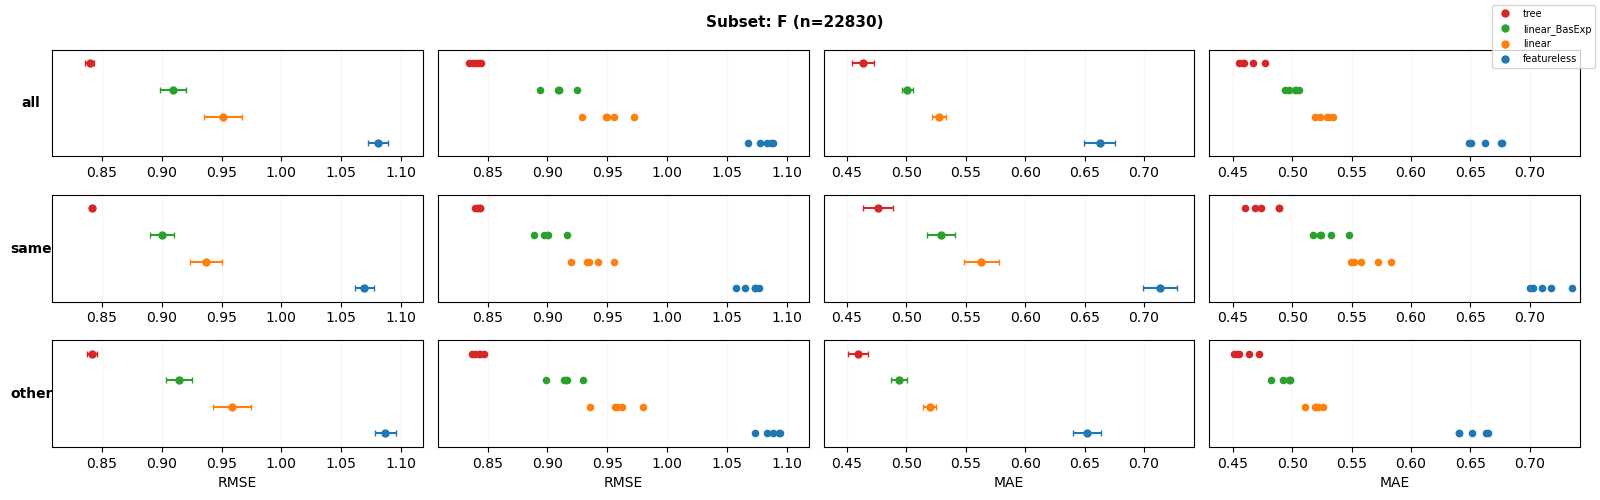

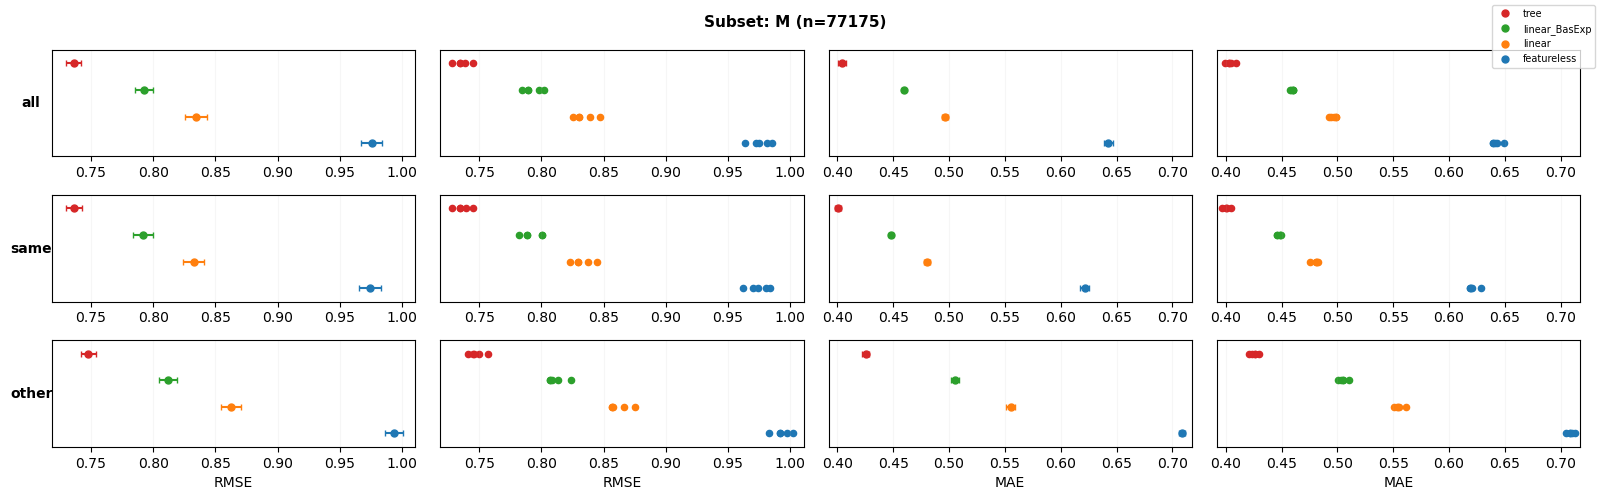

In [4]:
soak_plot_multiple_models(results_df)

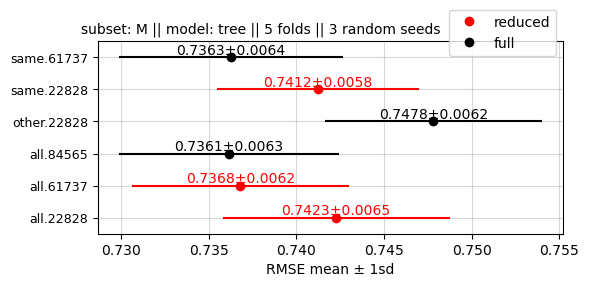

In [5]:
soak_plot_one_model(results_df, subset_value='M', model='tree')

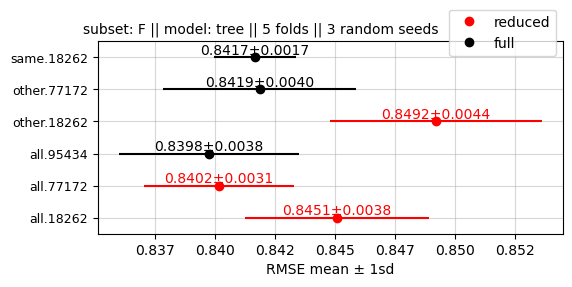

In [6]:
soak_plot_one_model(results_df, subset_value='F', model='tree')

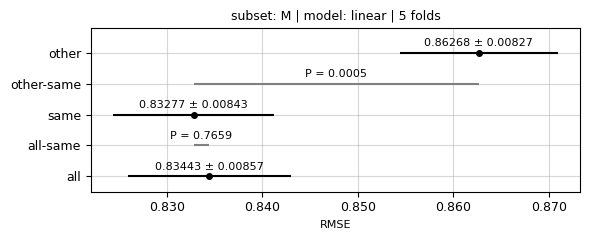

In [7]:
soak_plot_one_model_extend(results_df, subset_value, model)

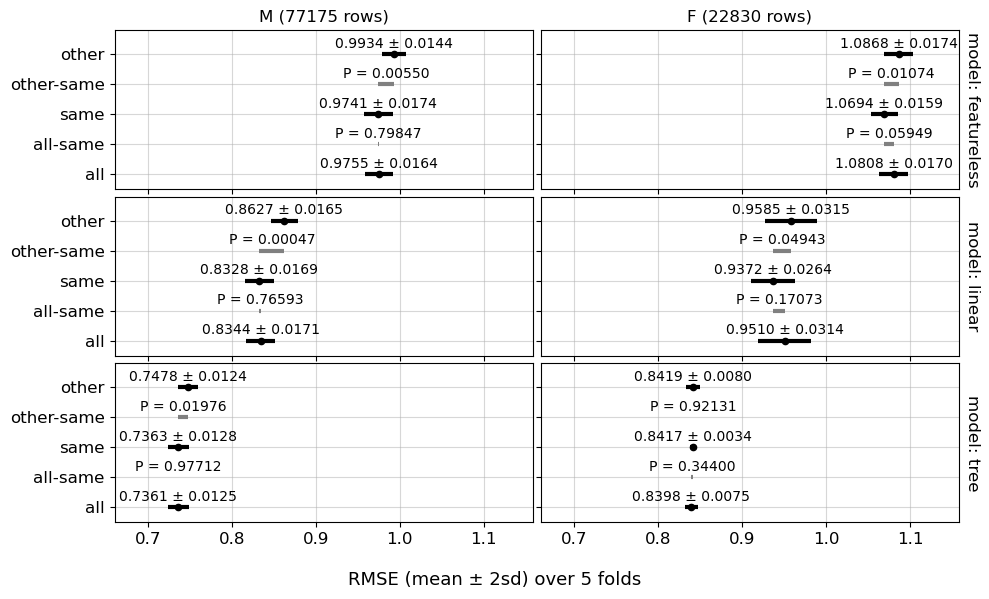

In [8]:
soak_plot_matrix(results_df, models=["featureless", "linear", "tree"], subset_values=["M", "F"], metric='rmse', subplot_size=(5, 2), extend=(0.0099, 0.0055))